# **Target**:
    less than 10k params
    uses dropout of 0.1 
    uses batchnorm
    uses randomrotate transform
    uses StepLR with step size = 6 and gamma = 0.1
    achieves 99.3% test accuracy


# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # In: 28x28x1 | output_size: 26x26x8 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # In: 26x26x8 | output_size: 24x24x10 | RF: 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
        ) # In: 24x24x10 | output_size: 22x22x12 | RF: 7

         # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 22x22x12 | output_size: 11x11x12 | RF: 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # In: 11x11x12 | output_size: 9x9x16 | RF: 12

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # In: 9x9x16 | output_size: 7x7x16 | RF: 16
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        ) # In: 7x7x16 | output_size: 5x5x16 | RF: 20

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # In: 1x1x10 | output_size: 1x1x10 | RF: 28
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 5x5x16 | output_size: 1x1x16 | RF: 28
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # In: 1x1x16 | output_size: 1x1x10 | RF: 28

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # In: 1x1x10 | output_size: 1x1x10 | RF: 28
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # In: 1x1x10 | output_size: 1x1x10 | RF: 28


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,080
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,728
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
          Dropout-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.011037826538085938 Batch_id=1874 Accuracy=87.11: 100%|██████████| 1875/1875 [00:28<00:00, 65.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0690, Accuracy: 9792/10000 (97.92%)

EPOCH: 2


Loss=0.07108351588249207 Batch_id=1874 Accuracy=96.84: 100%|██████████| 1875/1875 [00:27<00:00, 67.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.16875626146793365 Batch_id=1874 Accuracy=97.49: 100%|██████████| 1875/1875 [00:27<00:00, 67.21it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9882/10000 (98.82%)

EPOCH: 4


Loss=0.27669236063957214 Batch_id=1874 Accuracy=97.84: 100%|██████████| 1875/1875 [00:27<00:00, 67.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.010029226541519165 Batch_id=1874 Accuracy=97.98: 100%|██████████| 1875/1875 [00:27<00:00, 68.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.004362821578979492 Batch_id=1874 Accuracy=98.13: 100%|██████████| 1875/1875 [00:27<00:00, 79.94it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.015203237533569336 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [00:27<00:00, 68.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.00535699725151062 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [00:27<00:00, 67.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.007647320628166199 Batch_id=1874 Accuracy=98.81: 100%|██████████| 1875/1875 [00:27<00:00, 67.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.0052035897970199585 Batch_id=1874 Accuracy=98.81: 100%|██████████| 1875/1875 [00:27<00:00, 74.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99.48%)

EPOCH: 11


Loss=0.03540618717670441 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:27<00:00, 67.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9948/10000 (99.48%)

EPOCH: 12


Loss=0.012037798762321472 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [00:27<00:00, 80.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.04399549961090088 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:27<00:00, 68.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 14


Loss=0.02463008463382721 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:27<00:00, 67.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9947/10000 (99.47%)

EPOCH: 15


Loss=0.002449601888656616 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:27<00:00, 75.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9949/10000 (99.49%)

EPOCH: 16


Loss=0.010730177164077759 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:27<00:00, 67.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.013066187500953674 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:27<00:00, 68.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.0164908766746521 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:27<00:00, 67.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 19


Loss=0.000749245285987854 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:28<00:00, 66.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9950/10000 (99.50%)

EPOCH: 20


Loss=0.0015794634819030762 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:27<00:00, 67.08it/s]



Test set: Average loss: 0.0188, Accuracy: 9946/10000 (99.46%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

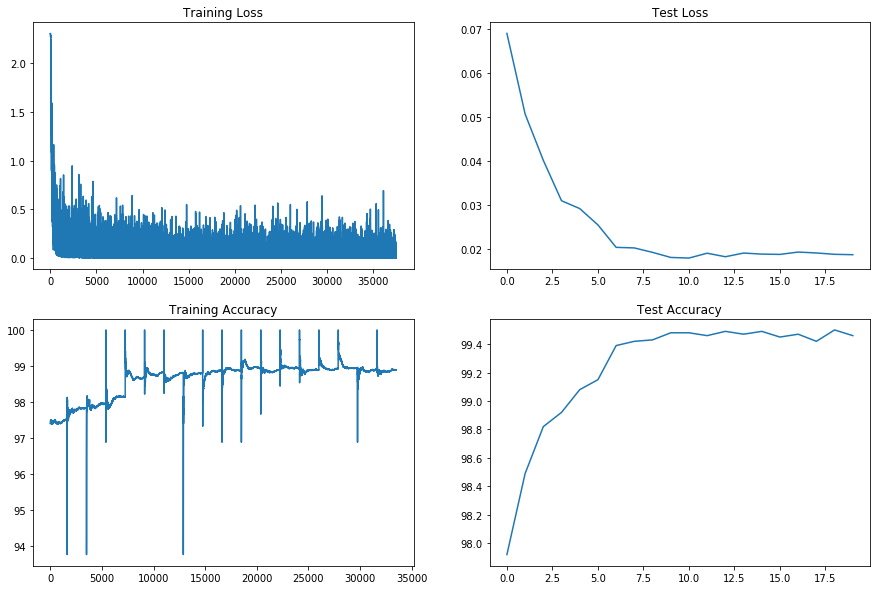

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")